# Free energy differences of two harmonic oscillators

In [1]:
from simtk import openmm, unit
from pymbar import timeseries as ts
import numpy as np
import matplotlib.pyplot as plt
from openmmtools.integrators import GHMCIntegrator
from time import time
%matplotlib inline

In [2]:
def strip_in_unit_system(quant, unit_system=unit.md_unit_system, compatible_with=None):
    """
    Strips the unit from a simtk.units.Quantity object and returns it's value conforming to a unit system
    Parameters
    ----------
    quant : simtk.unit.Quantity
        object from which units are to be stripped
    unit_system : simtk.unit.UnitSystem:
        unit system to which the unit needs to be converted, default is the OpenMM unit system (md_unit_system)
    compatible_with : simtk.unit.Unit
        Supply to make sure that the unit is compatible with an expected unit
    Returns
    -------
    quant : object with no units attached
    """
    if unit.is_quantity(quant):
        if compatible_with is not None:
            quant = quant.in_units_of(compatible_with)
        return quant.value_in_unit_system(unit_system)
    else:
        return quant

In [5]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
class BayesianHarmonicSwapper(object):
    """
    Class for testing Bayesian Mixture Sampling on a 3D harmonic oscillator. The harmonic oscillator is allowed to
    alternate the force constant between two set values.
    """
    
    def __init__(self, sigma1 = 5.0 * unit.angstrom, sigma2 = 10.0 * unit.angstrom, temperature = 300.0 * unit.kelvin,
                 zeta = (0.0, 0.0), mass = 39.948 * unit.amu, collision_rate = 5.0/unit.picosecond, platform_name = 'CPU'):
        """
        Initialize the 3D harmonic oscillator with two force constants
        """
        
        if len(zeta) != 2:
            raise Exception('zeta must be a list or tuple of floats with length 2')
        
        # System specific
        self.mass = mass
        self.temperature = temperature
        self.kT = kB * self.temperature 
        self.kT_unitless = strip_in_unit_system(self.kT)
        self.platform_name = platform_name
                
        # Force Constants
        K1 = (self.kT / sigma1**2).in_unit_system(unit.md_unit_system)
        K2 = (self.kT / sigma2**2).in_unit_system(unit.md_unit_system) 

        self.K = (K1,K2)
        self.zeta = (zeta[0],zeta[1])
        
        
        # Choose the intiial force constant
        self.state = np.random.choice((0,1))
        self.K_current = self.K[self.state]
        self.zeta_current = self.zeta[self.state]
        
        #self.K_current = np.random.choice((self.K1, self.K2))
        #self.K_current_unitless = strip_in_unit_system(self.K_current)
        
        # Integrator specific
        self.collision_rate = collision_rate  
        tau = 2 * np.pi * unit.sqrt(self.mass / (K1/2.0 + K2/2.0)) # time constant
        self.timestep = tau / 20.0

        # The openmm system
        (self.context, self.integrator, self.system) = self.make_harmonic_context(self.K_current)
        
        # The counting statistics, which tracks the number in the second state
        self.state_counter = 0
        self.nmoves = 0
        
    def make_harmonic_context(self, K, positions = None, velocities = None):
        """
        Create the system in openmm with for a specified force constant.
        """
        # Create the system and harmonic force
        system = openmm.System()
        system.addParticle(self.mass)
        energy_expression = '(K/2.0) * (x^2 + y^2 + z^2);'
        force = openmm.CustomExternalForce(energy_expression)
        force.addGlobalParameter('K', K.in_unit_system(unit.md_unit_system))
        force.addParticle(0, [])
        system.addForce(force)

        # Create the integrator and context
        integrator = openmm.LangevinIntegrator(self.temperature, self.collision_rate, self.timestep)
        platform = openmm.Platform.getPlatformByName(self.platform_name)
        context = openmm.Context(system, integrator, platform)
    
        # Set the positions and velocities.
        if positions is None:
            positions = unit.Quantity(np.zeros([1, 3], np.float32), unit.angstroms)
        context.setPositions(positions)
        if velocities is None:
            context.setVelocitiesToTemperature(self.temperature)
        else:
            context.setVelocities(velocities)
    
        return context, integrator, system   

    def get_energy(self, positions, K):
        """
        Calculate the harmonic bond energy for a given set of positions and force constant.
        
        Parameters
        ----------
        positions: numpy array of floats
          the x,y,z coordinates of the particle
        K : float
          the force constant in the openmm units
        
        Returns
        -------
        energy: float
          the energy of the harmonic oscillator
        
        """
        return np.sqrt(np.sum(positions**2)) * K / 2.0 / self.kT_unitless

    def attempt_swap(self):
        """
        Metropolis-Hastings trial move to change the force constant
        
        Returns
        -------
        state: int
          the index of the current state (either 0 or 1)
        """
    
        # Mixture sampling with Metropolis-Hastings
        initial_positions = self.context.getState(getPositions=True).getPositions(asNumpy=True)
        initial_velocities = self.context.getState(getVelocities=True).getVelocities(asNumpy=True)        
        initial_energy = self.get_energy(initial_positions, strip_in_unit_system(self.K_current) )
        initial_K = self.K_current
        
        # Pick a random force constant
        new_state = np.random.choice((0, 1))
        new_K = self.K[new_state]
        new_zeta = self.zeta[new_state]
        if new_state != self.state :
            final_energy = self.get_energy(initial_positions, strip_in_unit_system(new_K))
            log_accept = -(final_energy - initial_energy) + (new_zeta - self.zeta_current)
            if  (log_accept > 0.0) or (np.random.random() < np.exp(log_accept)):
                self.K_current = new_K
                self.zeta_current = new_zeta
                (self.context, self.integrator, self.system) = self.make_harmonic_context(self.K_current, initial_positions, initial_velocities)
                self.state = new_state
        return self.state
                
    def mixture_sample(self, niterations = 100, save_freq = 10, nsteps=100):
        """
        Cycle between label sampling and configuration sampling, where configurations are sampled with openmm.
        
        Parameters
        ----------
        niterations: int
          the number of cycles of configuration sampling and state sampling
        save_freq: int
          the frequency with which the state will be recorded. A device to thin the data
        nsteps: int
          the number of moleculear dynamics moves per iteration
        """ 
        for iteration in range(niterations):
            # Configuration sampling
            self.integrator.step(nsteps)
            state = self.attempt_swap()
            if iteration % save_freq:
                self.nmoves += 1
                self.state_counter += state

In [6]:
swapper = BayesianHarmonicSwapper(sigma1 = 5.0 * unit.angstrom, sigma2 = 7.0 * unit.angstrom)
swapper.mixture_sample(niterations=500)
print 'fraction in state 1 = {0:f}'.format(1.0*swapper.state_counter / swapper.nmoves)

In [7]:
print 'fraction in state 1 = {0:f}'.format(1.0*swapper.state_counter / swapper.nmoves)
print 'nsuccess = {0}, nmoves = {1}'.format(swapper.state_counter,swapper.nmoves)

fraction in state 1: 0.757777777778
nsuccess = 682, nmoves = 900


## Preliminary example of the OpenMM harmonic oscillator

The code developed here formed the basis of the `BayesianHarmonicSwapper` class in `harmonic_mixture_sampler.py`. The harmonic oscillator model used is based on https://github.com/choderalab/perses/blob/master/perses/tests/test_ncmc_integrator.py.

In the last cell, it's shown that about 100 to 200 steps of Langevin dynamics are sufficient to produce effectively uncorrelated samples of radii.

In [8]:
# Parameters for 3D harmonic oscillator
mass = 39.948 * unit.amu # mass of particle (argon)
sigma = 5.0 * unit.angstrom # standard deviation of harmonic oscillator
collision_rate = 5.0/unit.picosecond # collision rate
temperature = 300.0 * unit.kelvin # temperature
platform_name = 'CPU'


# Compute derived quantities.
kT = kB * temperature # thermal energy
beta = 1.0 / kT # inverse energy
K = kT / sigma**2 # spring constant
tau = 2 * np.pi * unit.sqrt(mass/K) # time constant
timestep = tau / 20.0
platform = openmm.Platform.getPlatformByName(platform_name)

def make_harmonic_context(K, positions = None, velocities = None):
    # Create the system and harmonic force
    system = openmm.System()
    system.addParticle(mass)
    energy_expression = '(K/2.0) * (x^2 + y^2 + z^2);'
    force = openmm.CustomExternalForce(energy_expression)
    force.addGlobalParameter('K', K.in_unit_system(unit.md_unit_system))
    force.addParticle(0, [])
    system.addForce(force)

    # Create the integrator and context
    integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
    platform = openmm.Platform.getPlatformByName(platform_name)
    context = openmm.Context(system, integrator, platform)
    
    # Set the positions and velocities.
    if positions is None:
        positions = unit.Quantity(np.zeros([1, 3], np.float32), unit.angstroms)
    context.setPositions(positions)
    if velocities is None:
        context.setVelocitiesToTemperature(temperature)
    else:
        context.setVelocities(velocities)
    return context, integrator, system    
    
    
    
# Create a 3D harmonic oscillator with context parameter controlling force constant
system = openmm.System()
system.addParticle(mass)
energy_expression = '(K/2.0) * (x^2 + y^2 + z^2);'
force = openmm.CustomExternalForce(energy_expression)
force.addGlobalParameter('K', K.in_unit_system(unit.md_unit_system))
#force.addPerParticleParameter('K', K.in_unit_system(unit.md_unit_system))
force.addParticle(0, [])
system.addForce(force)

# Create the integrator and context
#integrator = GHMCIntegrator(temperature, collision_rate, timestep)
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
platform = openmm.Platform.getPlatformByName(platform_name)
context = openmm.Context(system, integrator, platform)
 # Set the positions at the origin.
positions = unit.Quantity(np.zeros([1, 3], np.float32), unit.angstroms)
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)

### What number of steps produces effectively uncorrlated samples?
MD steps of 100 to 200 are sufficient to produce effectively uncorrelated samples of the harmonic oscillator radius.

Mean radius = 0.986238002777 Angstroms
Variance =  0.198491
Statisitcal inefficieny = 1.000000


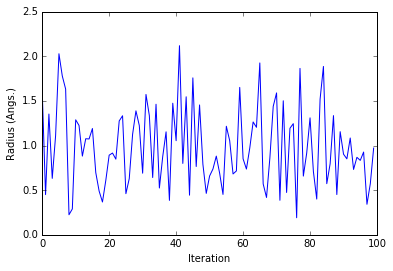

In [11]:
iterations = 100
radii = np.zeros(iterations,dtype=np.float32)

for i in range(iterations):
    integrator.step(150)
    pos = context.getState(getPositions=True).getPositions(asNumpy=True)
    pos = strip_in_unit_system(pos)[0]
    radii[i] = np.sqrt(np.sum(pos**2))

print 'Mean radius = {0} Angstroms'.format(np.mean(radii))
print 'Variance = ', np.var(radii)
print 'Statisitcal inefficieny = {:f}'.format(ts.statisticalInefficiency(radii))

plt.plot(radii)
plt.xlabel('Iteration')
plt.ylabel('Radius (Angs.)')
plt.show()